In [2]:
import pandas as pd
import json
import os

import math
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from collections import deque, defaultdict, Counter
import uuid

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
DATA_PATH = os.path.expanduser("~/data")

In [6]:
flags = pd.read_json("{}/table_balanced.json".format(DATA_PATH))

In [7]:
flags.shape

(22788, 9)

In [8]:
flags = flags.drop_duplicates(subset=['sha'])

In [13]:
with open("{}/balanced_ids.txt".format(DATA_PATH), 'w') as f:
    for id in flags['sha']:
        f.write("{}\n".format(id))

In [23]:
flags.columns.values

array([u'flag-any', u'flag-easylist', u'flag-easyprivacy',
       u'flag-fanboy-annoyance', u'flag-fanboy-social', u'inline', u'sha',
       u'url'], dtype=object)

In [24]:
flags.index = flags.sha

In [14]:
np.sum(flags['flag-any'] == 1.0)*1.0 / np.sum(flags['flag-any'] != 1.0)

1.0

In [28]:
with open("{}/ast-10k-tree.jsonl".format(DATA_PATH)) as f:
    raw_asts = (entry.split("\t") for entry in f.readlines())
    labels = []
    features = []
    for id, ast in raw_asts:
        label = [
            int(flags.loc[[id]]["flag-easylist"]),
            int(flags.loc[[id]]["flag-easyprivacy"]),
            int(flags.loc[[id]]["flag-fanboy-annoyance"]),
            int(flags.loc[[id]]["flag-fanboy-social"])
        ]
        labels.append(label)
        features.append( Counter(json.loads(ast)) )

In [60]:
no_flag = [i for i,l in enumerate(labels) if l == [0.0, 0.0, 0.0, 0.0]]
flag_any = [i for i,l in enumerate(labels) if l != [0.0, 0.0, 0.0, 0.0]]

In [61]:
sampled = np.random.choice(no_flag, len(labels) - len(no_flag)) 

In [62]:
features_sampled = [features[i] for i in sampled] + [features[i] for i in flag_any]
labels_sampled = [labels[i] for i in sampled] + [labels[i] for i in flag_any]

In [192]:
def tree_distance(c1, c2):
    keys = set(c1.keys()).union(c2.keys())
    s = 0.0
    for k in keys:
        diff = c1[k] - c2[k]
        s = s + (diff * diff)
    return s

In [193]:
n = len(features_sampled)
X = np.zeros(dtype='float32', shape=[n, n])

for i in xrange(n):
    for j in xrange(i, n):
        m = tree_distance(features_sampled[i], features_sampled[j])
        X[i, j] = m
        X[j, i] = m

In [179]:
all_keys = set()
for feat in features_sampled:
    for key in feat.keys():
        all_keys.add(key)

all_keys = dict((k,i) for i,k in enumerate(all_keys))

In [182]:
X2 = np.zeros(dtype='float32', shape=[n, len(all_keys)])
for j, feat in enumerate(features_sampled):
    for k,c in feat.iteritems():
        i = all_keys[k]
        X2[j,i] = c

In [187]:
idf = np.zeros(dtype='float32', shape=[X2.shape[1]])
for t,i in all_keys.iteritems():
    nd = np.sum((1.0 if t in f else 0.0) for f in features_sampled)
    idf[i] = nd

In [189]:
X2 = np.apply_along_axis(lambda r:r/idf, 1, X2)

In [64]:
Y = np.array(labels_sampled, dtype='float32')

In [194]:
tsne = TSNE(perplexity=50, n_components=2, n_iter=5000, metric="precomputed")
X2d = tsne.fit_transform(X)

In [66]:
X2d

array([[ 25.15349168,  12.26491918],
       [  4.76051152,  -1.74432816],
       [-28.6698593 ,  31.04975808],
       ..., 
       [ 21.27636665, -23.69653532],
       [-19.70520563,  -9.09272111],
       [ -7.54774902, -16.06308978]])

In [ ]:
indices_no_flag = np.where()

In [147]:
def get_color(label):
    if np.sum(label) == 0.0:
        return 'grey'
    colors = ['red', 'purple', 'orange', 'pink']
    index, = np.where(label == 1.0)
    index = index[0]
    return colors[index]

def get_color_2class(label):
    if np.sum(label) > 0.0:
        return 'purple'
    else:
        return 'grey'

def get_marker(label):
    if np.sum(label) == 0.0:
        return 'o'
    markers = ['^', '>', 'v', '^']
    index, = np.where(label == 1.0)
    index = index[0]
    return markers[index]

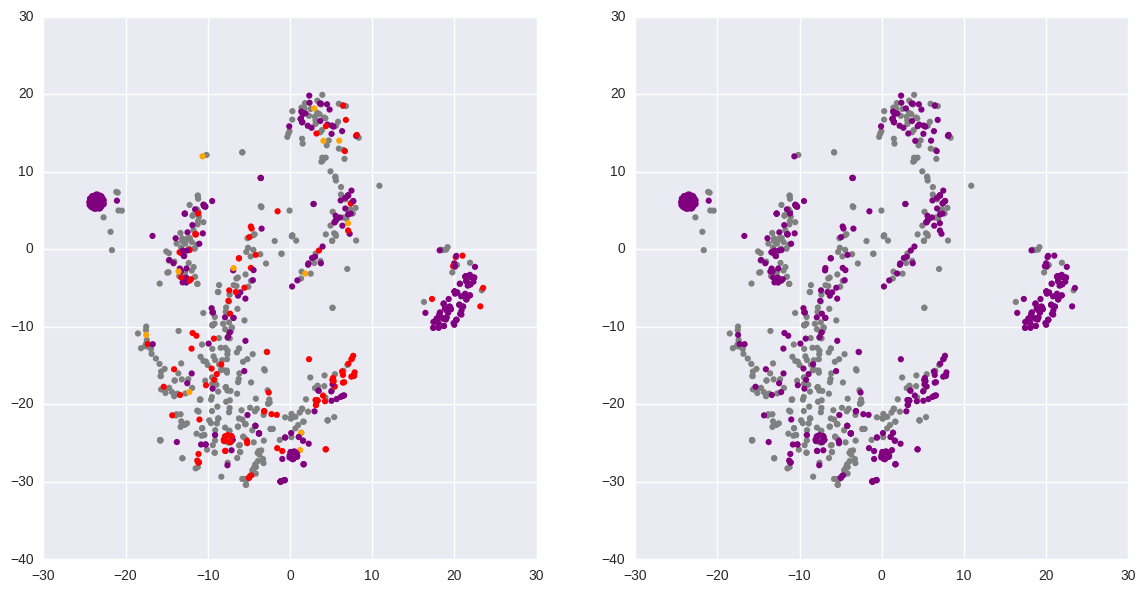

In [195]:
colors  = [get_color(y) for y in Y]
colors2 = [get_color_2class(y) for y in Y]


fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
ax1.scatter(*X2d.T, c=colors, marker='o', linewidths=0)
# ax1.set_title("Tree Similarity - Size and Transparency is Proportional to Log(ast_size)")
ax2.scatter(*X2d.T, c=colors2, marker='o', linewidths=0)
# ax2.set_title("Tree Similarity - Plain Scatter Plot of TSNE Features")

In [151]:
Y_any = (np.sum(Y, axis=1) > 0.0)

In [93]:
from sklearn.svm import SVC
from sklearn.metrics.pairwise import chi2_kernel

In [217]:
mat = np.log(X+1.0)
sims = np.exp(-mat)

indices = np.random.permutation(n)
itrain, itest = indices[:600], indices[600:]
x_train, x_test = sims[itrain][:,itrain], sims[itest][:,itrain]
y_train, y_test = Y_any[itrain], Y_any[itest]

svm = SVC(kernel='precomputed').fit(x_train, y_train)
svm.score(x_test, y_test)

0.721830985915493

In [38]:
svm.score(x_train, y_train)

0.98333333333333328